# MNIST

In [43]:
import numpy as np
import pandas as pd

from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.style(theme="oceans16")

import warnings
warnings.filterwarnings("ignore")

## Global config

In [44]:
# TODO
import os
os.chdir("./")

## Load data

In [45]:
mnist_28x28_train = np.load("mnist_28x28_train.npy")
mnist_8x8_train = np.load("mnist_8x8_train.npy")
train_labels = np.load("train_labels.npy")

mnist_28x28_test = np.load("mnist_28x28_test.npy")
mnist_8x8_test = np.load("mnist_8x8_test.npy")

## Helpers

##  Data exploration

### Question 1
Hint: `plt.imshow`
<p><span style="color:#ffd700">
(1 point) Explore the dataset by plotting the same image from both datasets side by
side. How do these images compare? Which dataset do you expect to perform better?
Clearly explain why you suspect that. Use no more than 75 words.
</span></p>
<p>
The 28*28 image has a higher resolution compared to 8*8, and the former is more understandable for human vision. Because of the higher resolution, the former dataset contains more pixels for each image, which means more information can obtain from it. 
</p>
<p>
28*28 dataset contains more features (suppose that each pixel is a feature) for each image. Assuming that the algorithm is enough to handle all pixels well, 28*28 will perform better.
</p>



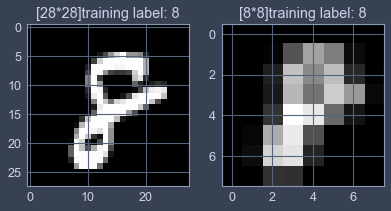

In [46]:
idx = 15
fig = plt.figure()
img28 = fig.add_subplot(1, 2, 1)
img8 = fig.add_subplot(1, 2, 2)
img28.set_title("[28*28]training label: " + str(train_labels[idx]))
img8.set_title("[8*8]training label: " + str(train_labels[idx]))
img28.imshow(mnist_28x28_train[idx,:,:], cmap='gray')
img8.imshow(mnist_8x8_train[idx,:,:], cmap='gray')
plt.show()

In [47]:
# to check whether the dataset is imbalanced

np.unique(train_labels, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64),
 array([395, 376, 367, 378, 388, 366, 371, 366, 366, 377], dtype=int64))

##  Data Preparations

### Question 1
<span style="color:#ffd700">
(3 points) Examine the features of both the datasets and decide if you need to do any
data cleaning or preprocessing. If not, clearly explain why not. If yes, clearly explain
why and what you did. Use no more than 100 words. (You might want to read the
additional reading materials).
</span>

The features are the intensities of the pixels. Both datasets are divided by 255, to map the original range of [0, 255] to [0, 1]. It is a kind of normalization. It can contribute to some algorithms which use gradient descent. Because the large inputs will lead to a large gradient each time, the learning rate should be very small. Learning rate is initialized randomly. If it is set to large at the beginning, it may skip the trough. We also flatten the pixels, as an estimator only accepts dimension less or equal to 2.

In [48]:
print("maximum value:", np.max(mnist_28x28_train))
print("minimum value:", np.min(mnist_28x28_train))

maximum value: 255
minimum value: 0


In [49]:
# the intensity of grayscale images is from 0 to 255, so we use 255 divides each dataset

mnist28_train = mnist_28x28_train.reshape([len(mnist_28x28_train),28*28])/255
mnist8_train = mnist_8x8_train.reshape([len(mnist_8x8_train),8*8])/255

mnist28_test = mnist_28x28_test.reshape([len(mnist_28x28_test),28*28])/255
mnist8_test = mnist_8x8_test.reshape([len(mnist_8x8_test),8*8])/255

print("current range:", "[", np.min(mnist28_train), ", ", np.max(mnist28_train),"]")

current range: [ 0.0 ,  1.0 ]


## Experiments

### Question 1
<span style="color:#ffd700">
(1 point) Now set up your experiment. Clearly explain how you divided the data and
how you ensured a valid measurement. Use no more than 100 words.
</span>

We decide to use KFlod cross-validation to train and test our models because it can make full use of the dataset and avoid the overfitting problem to some extent. The value of n_splits is set to 5, which means it will use 1 fold for validating, the rest 4 folds for training in one round. In terms of ensuring our measurements, we plotted the learning curve for each training process in order to compare the accuracy. (we do not use F1 because the dataset is balanced)

In [8]:
# build up five algorithms using default values as the requirements
random_state = 42
n_splits = 5

models = {
    "GaussianNB": GaussianNB(),
    
    "DecisionTreeClassifier": DecisionTreeClassifier(
        max_depth=None, 
        min_samples_leaf=2, 
        random_state=random_state
    ),
    
    "KNeighborsClassifier": KNeighborsClassifier(
        n_neighbors=3, 
        weights="distance"
    ),
    
    "SVM": SVC(
        C=10, 
        kernel="poly", 
        random_state=random_state
    ),
    
    "LogisticRegression": LogisticRegression(
        C=10,
        penalty="none",
        random_state=random_state
    ),
}

### Question 2
<span style="color:#ffd700">
(2 points) Fit the five algorithms using Scikit-learn’s default hyper-parameters. Create a
useful plot that shows the performances of the algorithms. Clearly explain what these
plots tell us about the performances of the algorithms. Also, clearly explain why you
think some algorithms perform better than others and why some of them preform better on one dataset than the other. Use no more than 200 words and two plots (but 1 is
sufficient).
</span>
<p>
Figure 1 shows the performance of five algorithms on the 28x28-pixel dataset, while figure 2 shows the performance on the 8x8-pixel dataset. No matter in which dataset, SVM always present the best learning ability, owning the highest accuracy 
<p>
The performance of the algorithm depends on the real distribution of the samples and the initial hyper-parameter. Since the digital writings are manufactured, Gaussian may perform worst on this kind of data. The ability of Decision Tree to deal with the numeric features is weak, so, it may perform worse on this kind of data. The rest of the three algorithms are doing well. They may have appropriate hyperparameters initially. If SVM performances well on this dataset, this dataset probably has a relatively clear margin of classification, which means there are a few overlapping samples of ten different classes. K-Neighbor locates at the second position, which has a slightly lower accuracy than SVM. Unlike American census dataset, the links between pixels and links between images may stronger, leading the better performance of K-Neighbor. Logistic regression owns the third ranking, because the gradient descent may be quite suitable to process image data.

In [9]:
# plot the learning curve
def learningCurve(X, Y):
#     initialize KFold cross-validation
    cv = KFold(n_splits=n_splits, random_state=random_state, shuffle=True)
    
    scoring_method_acc = make_scorer(lambda prediction, true_target:
                                 accuracy_score(true_target, prediction))
    for name, model in models.items():
        train_sizes, train_scores, valid_scores = learning_curve(model,
                                                                X, Y,
                                                                train_sizes=np.linspace(0.1, 1, 10),
                                                                cv=cv,
                                                                scoring=scoring_method_acc,
                                                                n_jobs=-1
                                                               )
        train_scores_mean = np.mean(train_scores, axis=1)
        valid_scores_mean = np.mean(valid_scores, axis=1)
        plt.plot(train_sizes, train_scores_mean)
        plt.plot(train_sizes, valid_scores_mean)
        plt.xlabel("train_sizes")
        plt.ylabel("accuracy_score")
        plt.title(name+"_learning_curve")
        plt.show()

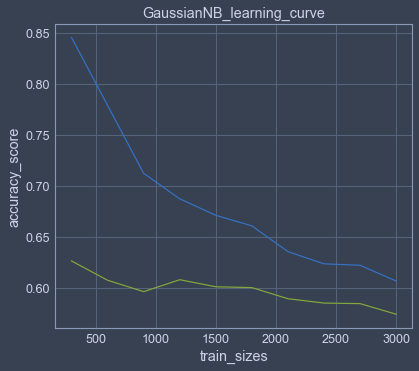

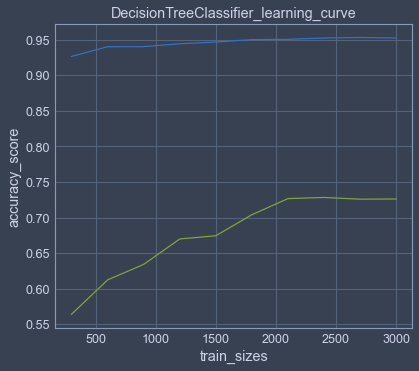

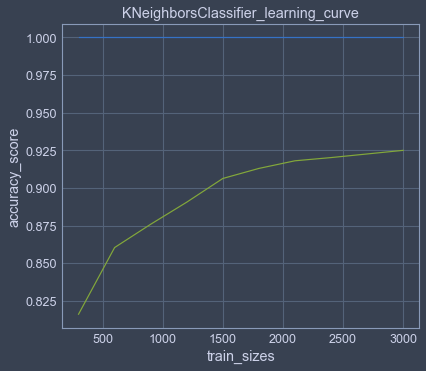

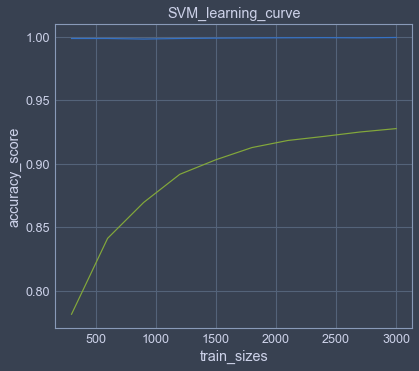

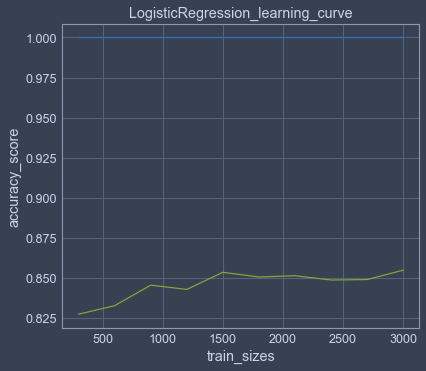

In [10]:
# the learning curves of each model for 28*28

learningCurve(mnist28_train, train_labels)

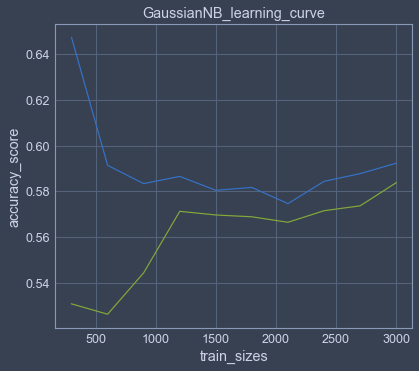

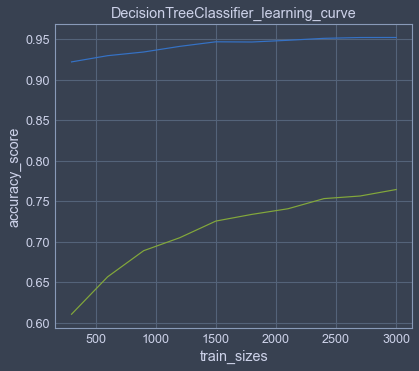

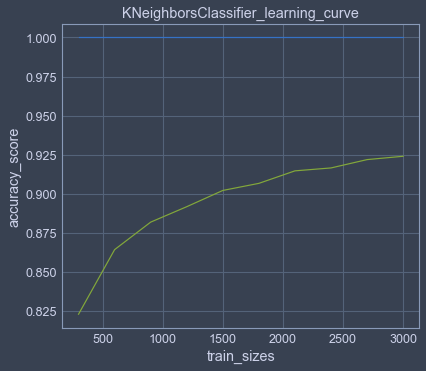

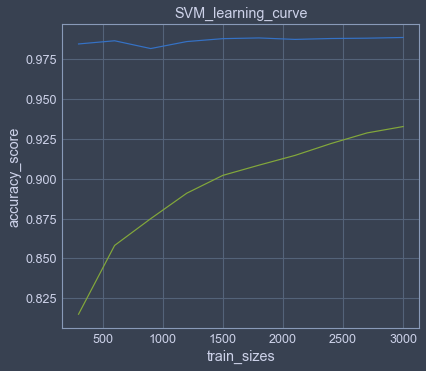

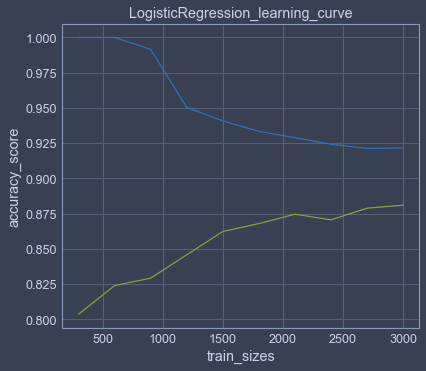

In [11]:
# the learning curves of each model for 8*8

learningCurve(mnist8_train, train_labels)

In [12]:
# Solution 1: visulization
# Then, we put all learning curves together to find the best one
# plot the learning curve
def learningCurveInOne(X, Y, saveName):
#     initialize KFold cross-validation
    cv = KFold(n_splits=n_splits, random_state=random_state, shuffle=True)
    
#     define the socring metric
    scoring_method_acc = make_scorer(lambda prediction, true_target:
                                 accuracy_score(true_target, prediction))

#     define the figure size and dpi
    plt.figure(figsize=(8,8), dpi=200)
    
#     start plotting
    for _, model in models.items():
        train_sizes, _, valid_scores = learning_curve(model,
                                                      X, Y,
                                                      train_sizes=np.linspace(0.1, 1, 10),
                                                      cv=cv,
                                                      scoring=scoring_method_acc,
                                                      n_jobs=-1
                                                     )
        valid_scores_mean = np.mean(valid_scores, axis=1)
        plt.plot(train_sizes, valid_scores_mean)
    plt.title("validating accuracy curves")
    plt.xlabel("train_sizes")
    plt.ylabel("accuracy")
    plt.legend([name for name, _ in models.items()], loc="upper left")
    plt.savefig("./figures/"+saveName)
    plt.show()

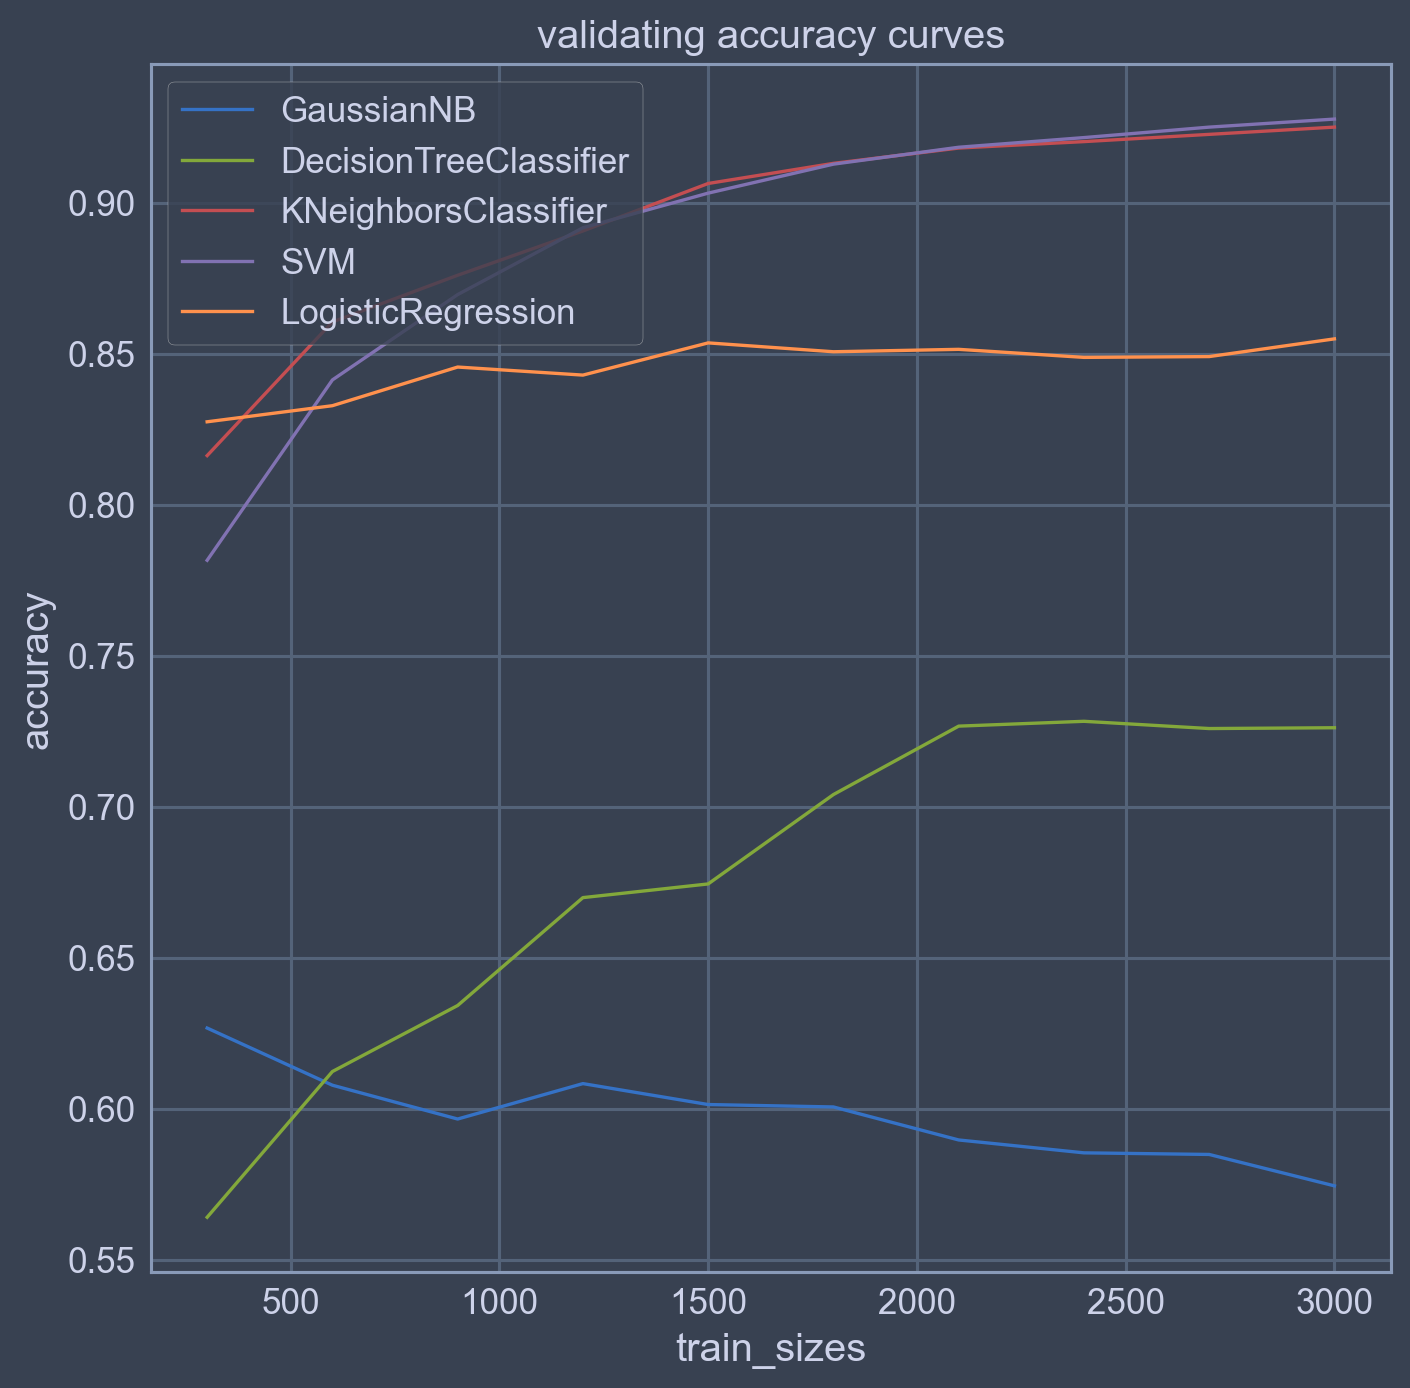

In [13]:
# plot the learning curves for 28*28

learningCurveInOne(mnist28_train, train_labels, "mnist28.png")

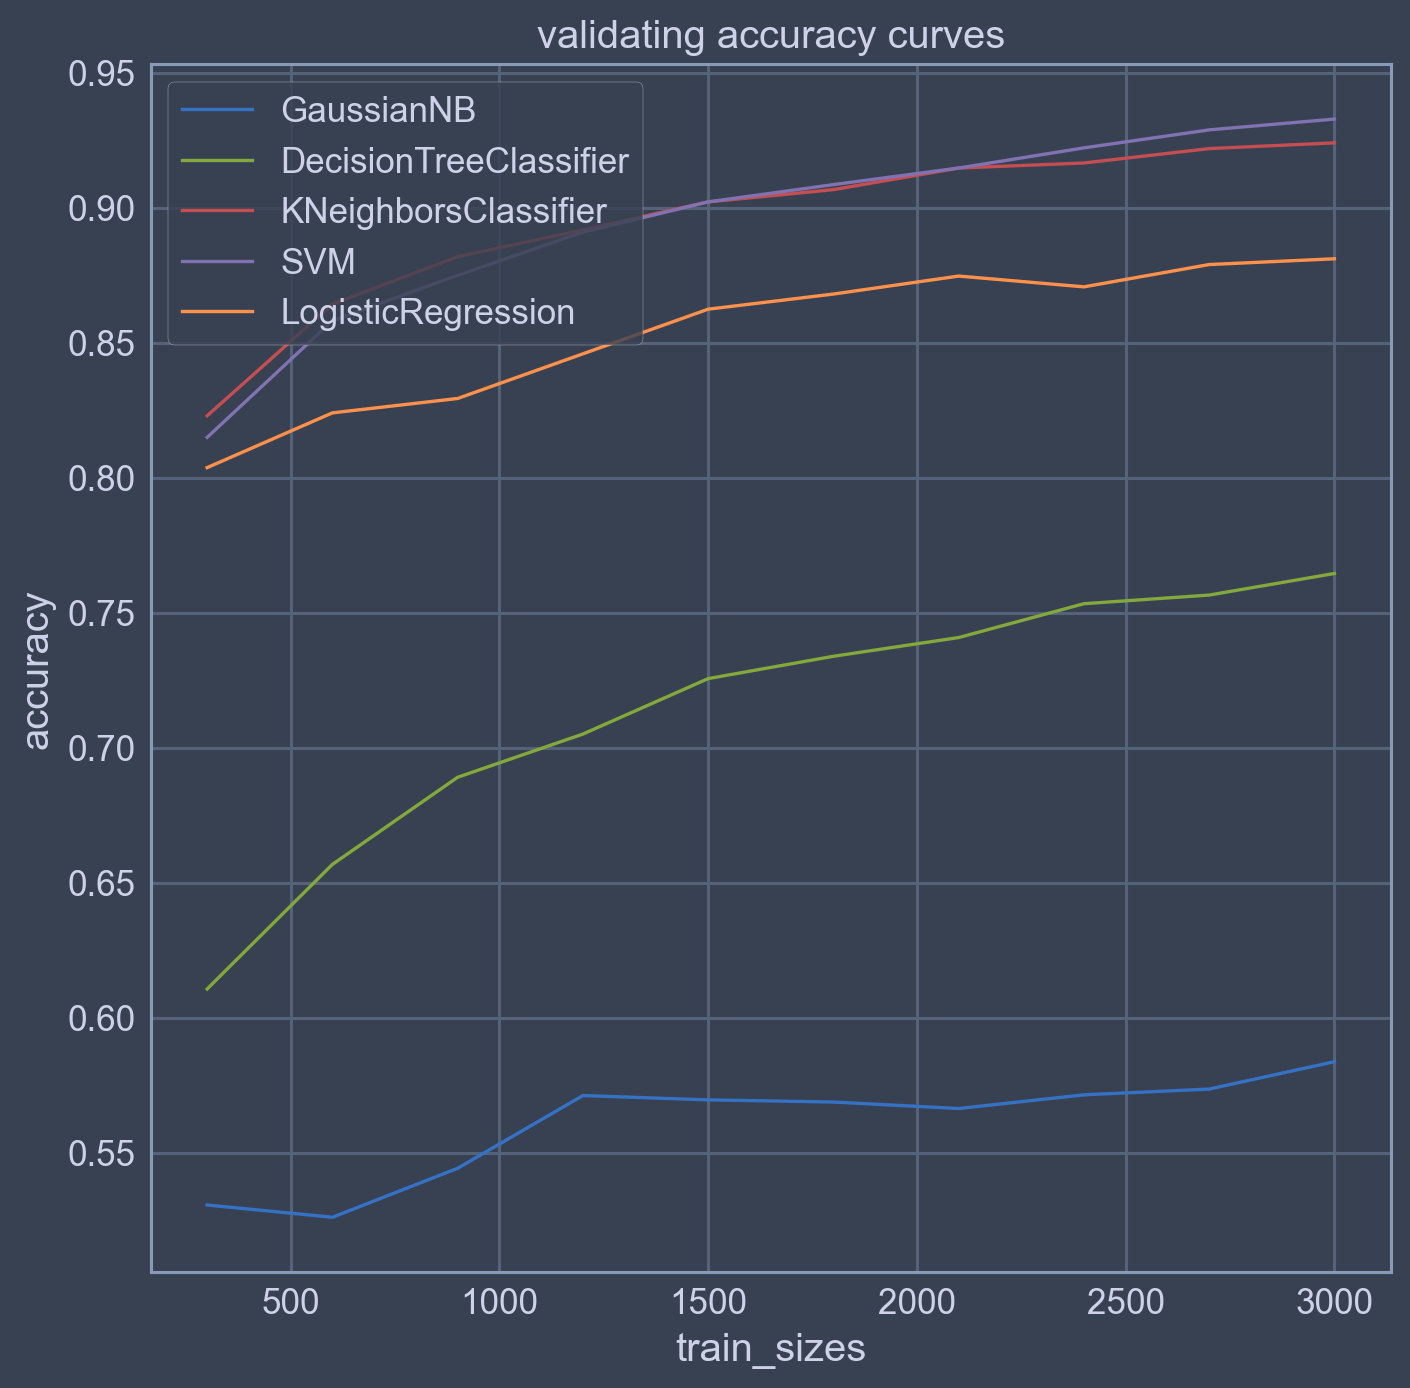

In [14]:
# plot the learning curves for 8*8

learningCurveInOne(mnist8_train, train_labels, "mnist8.png")

In [15]:
# Method 2: Only Show The Final Result
# generate measurements for validation (K-flod cross validation)
def k_fold_fit_and_evaluate(X, y, model, scoring_method, n_splits):
    # define evaluation procedure
    cv = KFold(n_splits=n_splits, random_state=random_state, shuffle=True)
    
    scores = cross_validate(model, X, y, scoring=scoring_method, cv=cv, n_jobs=-1)
    
    return scores["test_score"]

def accPrint(X, Y):
    scoring_method_acc = make_scorer(lambda prediction, true_target:
                                 accuracy_score(true_target, prediction))
    for name, model in models.items():
        print(name)
        metrics_acc = k_fold_fit_and_evaluate(X, Y, model, scoring_method_acc, n_splits=n_splits)
        print(" mean Accuracy", '\t', " std Accuracy")
        print(format(np.mean(metrics_acc),"5f"), '\t', format(np.std(metrics_acc),"5f"))
        print()

In [16]:
print("------------------28*28------------------")
accPrint(mnist28_train, train_labels)
print("-------------------8*8-------------------")
accPrint(mnist8_train, train_labels)

------------------28*28------------------
GaussianNB
 mean Accuracy 	  std Accuracy
0.574400 	 0.030280

DecisionTreeClassifier
 mean Accuracy 	  std Accuracy
0.726133 	 0.014226

KNeighborsClassifier
 mean Accuracy 	  std Accuracy
0.925067 	 0.002133

SVM
 mean Accuracy 	  std Accuracy
0.927733 	 0.008860

LogisticRegression
 mean Accuracy 	  std Accuracy
0.854933 	 0.012519

-------------------8*8-------------------
GaussianNB
 mean Accuracy 	  std Accuracy
0.583733 	 0.018231

DecisionTreeClassifier
 mean Accuracy 	  std Accuracy
0.764533 	 0.021854

KNeighborsClassifier
 mean Accuracy 	  std Accuracy
0.924000 	 0.006746

SVM
 mean Accuracy 	  std Accuracy
0.932800 	 0.004183

LogisticRegression
 mean Accuracy 	  std Accuracy
0.881067 	 0.012144



### Question 3
<span style="color:#ffd700">
(2 points) Now perform hyper-parameter tuning on the key hyper-parameters you have
previously identified. Clearly explain what you did and how you did this. Use no more
than 200 words.
</span>
<p>
    <b>Systematic</b>: In order to exhaustively search the best parameters, we adapt GridSearchCV. Using this method, we can define a group of values for each parameter of a model, which will be tested independently each time, and GridSearchCV will return the best combination of values for each algorithm.
<p>
    <b>Fairness</b>: We cannot access to the best values before training and validating. Therefore, we need to trial. Initially, we will set a rough range of values to test their performances. Then, we will narrow down the ranges of the parameters according to the feedback of GridSearchCV.  At the same time, we will check the learning curve of the current best algorithm to monitor the overfitting problem.
<p>
    <b>Trade-off</b>: The first limitation is the number of samples; therefore, every round we will feed the model with all samples. The second limitation is the wide range of parameters, and especially it will spend a long period for training if the ranges are set too wide. Therefore, we need to stop narrow down when the accuracy is not significantly promoted after tuning.


In [17]:
# set the testing range of parameters for each model
model_parameters = {
    "GaussianNB": {
    
    },
    
    "DecisionTreeClassifier": {
        'min_samples_leaf': [2, 4, 6, 8, 10],
        'max_depth': [None, 5, 10, 15, 20, 25],
        'random_state': [40, 41, 42, 43, 44]
    },
    
    "KNeighborsClassifier": {
        "n_neighbors": [3, 7, 9, 13, 15, 19],
        "weights": ["distance", "uniform"] 
    },
    
    "SVM": {
        "C": [5, 10, 15, 20, 25],
        "kernel": ['linear', 'poly', 'rbf', 'sigmoid'],
        "random_state": [40, 41, 42, 43, 44]
    },
    
    "LogisticRegression": {
        "C": [5, 10, 15, 20, 25],
        "penalty": ['l1', 'l2', 'elasticnet', 'none'],
        "random_state": [40, 41, 42, 43, 44]
    }
}

In [18]:

# In the first round, we want to find the best value in a rough range and find which dataset to be used

# for 28*28

scoring_method = make_scorer(lambda prediction, true_target:
                             accuracy_score(true_target, prediction))
cv = KFold(n_splits=n_splits, shuffle=True)

for model_name, parameters in model_parameters.items():
    model = models[model_name]
    grid_search = GridSearchCV(model, parameters, cv=cv, n_jobs=-1, verbose=False, scoring=scoring_method).fit(mnist28_train, train_labels)
    
    best_model = grid_search.best_estimator_
    best_score = grid_search.best_score_
    best_params = grid_search.best_params_
    
    print(model_name)
    print("- best_score =", best_score)
    print("best paramters:")
    for k,v in best_params.items():
        print("-", k, v)

GaussianNB
- best_score = 0.5733333333333334
best paramters:
DecisionTreeClassifier
- best_score = 0.7298666666666666
best paramters:
- max_depth None
- min_samples_leaf 6
- random_state 44
KNeighborsClassifier
- best_score = 0.9306666666666666
best paramters:
- n_neighbors 3
- weights distance
SVM
- best_score = 0.9498666666666665
best paramters:
- C 5
- kernel rbf
- random_state 40
LogisticRegression
- best_score = 0.8704000000000001
best paramters:
- C 5
- penalty l2
- random_state 40


In [19]:
# for 8*8

for model_name, parameters in model_parameters.items():
    model = models[model_name]
    grid_search = GridSearchCV(model, parameters, cv=cv, n_jobs=-1, verbose=False, scoring=scoring_method).fit(mnist8_train, train_labels)
    
    best_model = grid_search.best_estimator_
    best_score = grid_search.best_score_
    best_params = grid_search.best_params_
    
    print(model_name)
    print("- best_score =", best_score)
    print("best paramters:")
    for k,v in best_params.items():
        print("-", k, v)

GaussianNB
- best_score = 0.5610666666666667
best paramters:
DecisionTreeClassifier
- best_score = 0.7741333333333333
best paramters:
- max_depth None
- min_samples_leaf 6
- random_state 40
KNeighborsClassifier
- best_score = 0.9266666666666665
best paramters:
- n_neighbors 3
- weights distance
SVM
- best_score = 0.9514666666666667
best paramters:
- C 20
- kernel rbf
- random_state 40
LogisticRegression
- best_score = 0.8896000000000001
best paramters:
- C 5
- penalty l2
- random_state 40


In [20]:
# set the testing range of parameters for each model for the second round

# for 28*28

model_parameters_for28 = {
    "DecisionTreeClassifier": {
        'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
#         since we have so many features, it will be better to restrict the max_depth
        'max_depth': [5, 7, 9, 11, 13, 15],
        'random_state': [40, 41, 42, 43, 44]
    },
    
    "KNeighborsClassifier": {
        "n_neighbors": [3, 5],
        "weights": ["distance"] 
    },
    
    "SVM": {
        "C": [6, 8, 9, 10, 11, 12, 14],
        "kernel": ['rbf'],
        "random_state": [40, 41, 42, 43, 44]
    },
    
    "LogisticRegression": {
        "C": [1, 2, 3, 4, 5, 6, 7, 8],
        "penalty": ['l2'],
        "random_state": [40, 41, 42, 43, 44]
    }
}

In [21]:
# the second round 

# for 28*28

for model_name, parameters in model_parameters_for28.items():
    model = models[model_name]
    grid_search = GridSearchCV(model, parameters, cv=cv, n_jobs=-1, verbose=False, scoring=scoring_method).fit(mnist28_train, train_labels)
    
    best_model = grid_search.best_estimator_
    best_score = grid_search.best_score_
    best_params = grid_search.best_params_
    
    print(model_name)
    print("- best_score =", best_score)
    print("best paramters:")
    for k,v in best_params.items():
        print("-", k, v)

DecisionTreeClassifier
- best_score = 0.7413333333333334
best paramters:
- max_depth 13
- min_samples_leaf 1
- random_state 41
KNeighborsClassifier
- best_score = 0.9296
best paramters:
- n_neighbors 3
- weights distance
SVM
- best_score = 0.9496
best paramters:
- C 6
- kernel rbf
- random_state 40
LogisticRegression
- best_score = 0.8792
best paramters:
- C 1
- penalty l2
- random_state 40


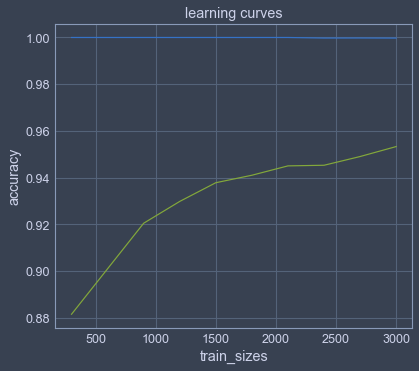

In [22]:
# the best one is SVM, but we need to check its learning curve to avoid overfitting problem

currentBest = SVC(C=6, kernel="rbf", random_state=40)

# check the correctness of our model
cv = KFold(n_splits=n_splits, shuffle=True)

scoring_method_acc = make_scorer(lambda prediction, true_target:
                                 accuracy_score(true_target, prediction))

train_sizes, train_scores, valid_scores = learning_curve(currentBest,
                                              mnist28_train, train_labels,
                                              train_sizes=np.linspace(0.1, 1, 10),
                                              cv=cv,
                                              scoring=scoring_method_acc,
                                              n_jobs=-1
                                             )
train_scores_mean = np.mean(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
plt.plot(train_sizes, train_scores_mean)
plt.plot(train_sizes, valid_scores_mean)
plt.title("learning curves")
plt.xlabel("train_sizes")
plt.ylabel("accuracy")
plt.show()

In [23]:
# ↑↑↑ it seems ok↑↑↑

In [24]:
# set the testing range of parameters for each model for the second round

# for 8*8

model_parameters_for8 = {
    "DecisionTreeClassifier": {
        'min_samples_leaf': [1, 2, 3, 4, 5],
        'max_depth': [17, 18, 19, 20, 21, 22, 23],
        'random_state': [40, 41, 42, 43, 44]
    },
    
    "KNeighborsClassifier": {
        "n_neighbors": [3, 5],
        "weights": ["distance"] 
    },
    
    "SVM": {
        "C": [6, 8, 9, 10, 11, 12, 14],
        "kernel": ['rbf'],
        "random_state": [40, 41, 42, 43, 44]
    },
    
    "LogisticRegression": {
        "C": [1, 2, 3, 4, 5, 6, 7, 8],
        "penalty": ['l2'],
        "random_state": [40, 41, 42, 43, 44]
    }
}

In [25]:
# for 8*8

for model_name, parameters in model_parameters_for8.items():
    model = models[model_name]
    grid_search = GridSearchCV(model, parameters, cv=cv, n_jobs=-1, verbose=False, scoring=scoring_method).fit(mnist8_train, train_labels)
    
    best_model = grid_search.best_estimator_
    best_score = grid_search.best_score_
    best_params = grid_search.best_params_
    
    print(model_name)
    print("- best_score =", best_score)
    print("best paramters:")
    for k,v in best_params.items():
        print("-", k, v)

DecisionTreeClassifier
- best_score = 0.7730666666666666
best paramters:
- max_depth 20
- min_samples_leaf 1
- random_state 40
KNeighborsClassifier
- best_score = 0.9258666666666666
best paramters:
- n_neighbors 5
- weights distance
SVM
- best_score = 0.9477333333333334
best paramters:
- C 8
- kernel rbf
- random_state 40
LogisticRegression
- best_score = 0.8885333333333334
best paramters:
- C 4
- penalty l2
- random_state 40


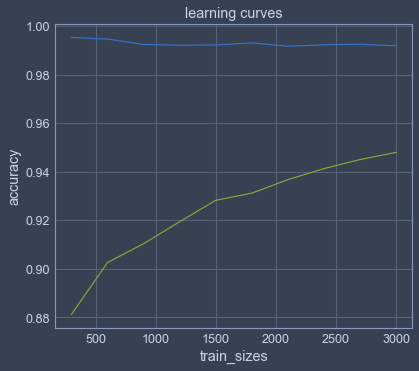

In [32]:
# the best one is SVM, but we need to check its learning curve to avoid overfitting problem

currentBest = SVC(C=8, kernel="rbf", random_state=40)

# check the correctness of our model
cv = KFold(n_splits=n_splits, shuffle=True)

scoring_method_acc = make_scorer(lambda prediction, true_target:
                                 accuracy_score(true_target, prediction))

train_sizes, train_scores, valid_scores = learning_curve(currentBest,
                                              mnist8_train, train_labels,
                                              train_sizes=np.linspace(0.1, 1, 10),
                                              cv=cv,
                                              scoring=scoring_method_acc,
                                              n_jobs=-1
                                             )
train_scores_mean = np.mean(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
plt.plot(train_sizes, train_scores_mean)
plt.plot(train_sizes, valid_scores_mean)
plt.title("learning curves")
plt.xlabel("train_sizes")
plt.ylabel("accuracy")
plt.show()

In [27]:
# ↑↑↑ it seems ok↑↑↑

In [28]:
# since the accuracy is high enough and the accuracy of SVM leads other algorithms too much, we decide not to run more rounds for tuning
# in conclusion, we will adapt 28*28-pixel dataset with the method of SVM

### Question 4 
<span style="color:#ffd700">
2.3.4	(2 points) Compare the performance of the algorithms with and without hyper-parameter tuning. Also, make a comparison with your original baseline. How did the tuning affect your result? Clearly explain the results and the differences. Use no more than 200 words and two plots (but 1 is sufficient).
</span>
<p>
In figure 3, it shows the learning curves of the algorithms after being tuned. Gaussian has no hyper-parameter tuning requirements, and K-Neighbor has the same values of the hyperparameter before and after being tuned, so, they are not presented in it. Due to the overfitting problem of Decision Tree algorithm, which is caused by a large quantity of features input, we have to restrict its max depth rather than use the default value “none”. Its accuracy goes down, but the overfitting is reduced. 
<p>
Turning to the current best two models, SVM is still at the top score, followed by logistic regression. the learning abilities of both algorithms have been improved after tuning. As we decrease the hyperparameter “C”, which is a kind of intensity of the penalty, the models tend to become more acceptable for other new samples. Tuning hyperparameters can promote the performance of an algorithm to some extent.


In [29]:
models = {    
    "DecisionTreeClassifier-default": DecisionTreeClassifier(
        max_depth=None, 
        min_samples_leaf=2, 
        random_state=random_state
    ),
    
    "DecisionTreeClassifier-tuned": DecisionTreeClassifier(
        max_depth=11, 
        min_samples_leaf=4, 
        random_state=43
    ),
    
    "SVM-default": SVC(
        C=10, 
        kernel="poly", 
        random_state=random_state
    ),
    
    "SVM-tuned": SVC(
        C=6, 
        kernel="rbf", 
        random_state=40
    ),
    
    "LogisticRegression-default": LogisticRegression(
        C=10,
        penalty="none",
        random_state=random_state
    ),
    
    "LogisticRegression-tuned": LogisticRegression(
        C=1,
        penalty="l2",
        random_state=40
    ),
}

In [30]:
def learningCurveInOne(X, Y, saveName):
#     initialize KFold cross-validation
    cv = KFold(n_splits=n_splits, shuffle=True)
    
#     define the socring metric
    scoring_method_acc = make_scorer(lambda prediction, true_target:
                                 accuracy_score(true_target, prediction))

#     define the figure size and dpi
    plt.figure(figsize=(8,8), dpi=200)
    
#     start plotting
    for _, model in models.items():
        train_sizes, _, valid_scores = learning_curve(model,
                                                      X, Y,
                                                      train_sizes=np.linspace(0.1, 1, 10),
                                                      cv=cv,
                                                      scoring=scoring_method_acc,
                                                      n_jobs=-1
                                                     )
        valid_scores_mean = np.mean(valid_scores, axis=1)
        plt.plot(train_sizes, valid_scores_mean)
    plt.title("validating accuracy curves")
    plt.xlabel("train_sizes")
    plt.ylabel("accuracy")
    plt.legend([name for name, _ in models.items()], loc="upper left")
    plt.savefig("./figures/"+saveName)
    plt.show()

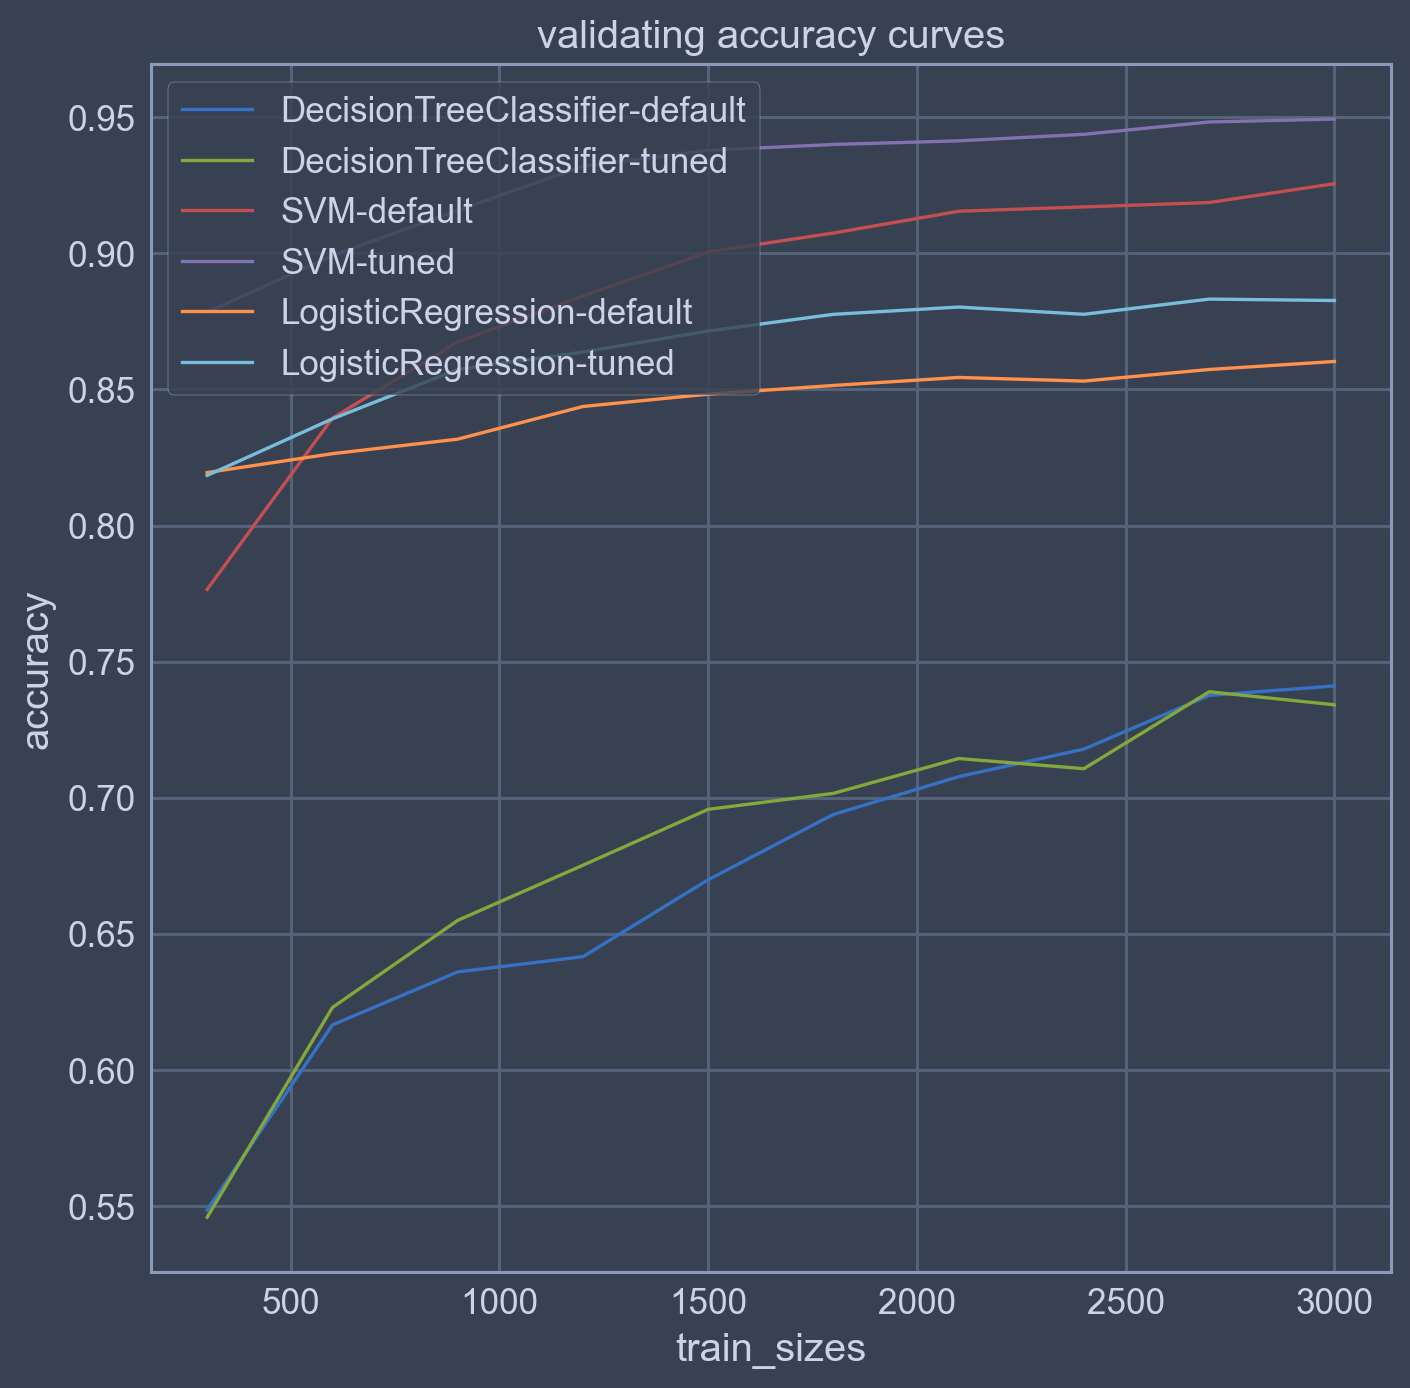

In [31]:
learningCurveInOne(mnist28_train, train_labels, "mnist28_tuned.png")

### Question 5
<span style="color:#ffd700">
(1 points) Compare the performance of the algorithms with the 8x8 and 28x28 features. What effect do the additional features have? Also, state what you think causes this effect. Use no more than 75 words.
</span>

The results are quite similar for both datasets. The additional features cannot significantly improve the performance of the algorithms. Higher resolution may contribute more to human understanding, but it means less to the machine. The lower resolution keeps the structure of the data. This can be a useful method for training high-quality images, in which we can reduce the pixels of an image similar to what convolutional layers does in CNN. 

### Question 6
<span style="color:#ffd700">
Select your best algorithm for this dataset and use it to make your predictions for the
unknown samples. Feel free to use either the 8x8 or 28x28 features. Please note in your
report which algorithm and feature set you chose.
</span>
<p>
We decide to choose Support Vector Machine with the following hyper-parameters, and to use 28x28-pixel dataset.
<p>
<b>C=6,
<p>
<b>kernel="rbf", 
<p>
<b>random_state=40

In [53]:
mymodel = SVC(C=6, kernel="rbf", random_state=40).fit(mnist28_train, train_labels)
prediction = mymodel.predict(mnist28_test)
pd.DataFrame(prediction).to_csv("GROUP_classes_problem_mnist.txt", index=False, header=False)

In [54]:
mymodel2 = SVC(C=8, kernel="rbf", random_state=40).fit(mnist8_train, train_labels)
prediction2 = mymodel2.predict(mnist8_test)

In [55]:
assert(len(mnist28_test) == len(mnist8_test))
print("similarity:", np.sum(prediction == prediction2)/len(mnist28_test))

similarity: 0.9664
